# Pipeline de Aplicación en Tiempo Real
Definimos un pipeline de aplicación que realiza las siguientes acciones:

- Recibe una solicitud del usuario.

- Enriquece la solicitud con características en tiempo real obtenidas del feature store.

- Envía las características enriquecidas a un ensamble de modelos (three-legged ensemble) que utiliza los modelos recientemente entrenados.

### Ventajas de MLRun en el Desarrollo de Pipelines

Construir un pipeline de este tipo tradicionalmente requeriría:

- Implementar múltiples microservicios.

- Escribir lógica compleja para gestionar el procesamiento en tiempo real, el enriquecimiento de datos y las predicciones.

Con MLRun, este proceso se simplifica considerablemente:

- Definición en pocas líneas de código: Puedes configurar todo el pipeline sin necesidad de construir microservicios adicionales.

- Despliegue automático: El pipeline se implementa como funciones serverless elásticas, escalables según la demanda.

#### Funcionalidades Automáticas del Framework de Serving de MLRun

- Imputación de características en tiempo real: Automatiza el procesamiento y asegura que las características necesarias estén disponibles al momento de las predicciones.

- Monitoreo de modelos: Supervisa el rendimiento y comportamiento de los modelos desplegados, detectando posibles desviaciones (model drift).

Este enfoque no solo simplifica el desarrollo, sino que también asegura una integración robusta para manejar solicitudes en tiempo real sin necesidad de escribir código adicional

In [ ]:
import mlrun
import numpy as np
from cloudpickle import load
from mlrun.serving.v2_serving import V2ModelServer

In [ ]:
project = mlrun.load_project(
    name="fraud-demo",
    context="./",
    user_project=True,
)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


## Definiendo una clase de servicio de modelo personalizada

MLRun tiene muchas clases de servicio de modelo integradas para diferentes frameworks (Sklearn, Xgboost, PyTorch, TensorFlow, ONNX, modelos de Hugging Face, etc.). También puedes construir tu propia clase de servicio de modelo personalizada, como se muestra en el Ejemplo 7-24. La clase de servicio debe admitir el método load() para cargar el modelo y el método predict() para hacer una predicción. Puedes leer la documentación de MLRun para ver todos los hooks y el uso avanzado.

In [2]:
# mlrun: start-code

In [ ]:
class ClassifierModel(V2ModelServer):
    
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))
        
    def predict(self, body: dict) -> list:
        """Generate model predictions from sample"""
        print(f"Input -> {body['inputs']}")
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

In [4]:
# mlrun: end-code

## Building an Application Pipeline with Enrichment and Ensemble

MLRun serving can produce managed real-time serverless pipelines from various tasks, including MLRun models or standard model files. The pipelines use the Nuclio real-time serverless engine, which can be deployed anywhere. Nuclio is a high-performance open-source serverless framework focused on data, I/O, and compute-intensive workloads.

The EnrichmentVotingEnsemble router class auto-enriches the request with data from the feature store. The router input accepts a list of inference requests (each request can be a dict or list of incoming features/keys). It enriches the request with data from the specified feature vector (feature_vector_uri), forwards the vector to one or more models in an ensemble, and returns an aggregated prediction value (for example, the average result across the three models).
The features can often have null values (None, NaN, Inf). The Enrichment_ routers can substitute the null value with fixed or statistical value per fea ture. This is done through the `impute_policy` parameter, which accepts the impute policy per feature (where * is used to specify the default). The value can be a fixed number for constants or $mean, $max, $min, $std, $count for statistical values to substitute the value with the equivalent feature stats (taken from the feature store).
The code in Example 7-24 defines a new serving function with the ClassifierModel class code (in serving.py) and a router topology (using the EnrichmentVotingEnsem ble router class) with three child models.

## Construcción de un Pipeline de Aplicación con Enriquecimiento y Ensamble

El framework de serving de MLRun permite construir pipelines serverless gestionados en tiempo real que combinan diversas tareas, incluidos modelos de MLRun o archivos de modelos estándar. Estos pipelines utilizan el motor serverless en tiempo real Nuclio, un framework de alto rendimiento, diseñado para tareas intensivas en datos, E/S y cómputo, que puede desplegarse en cualquier entorno.

### Clases de Enriquecimiento y Ensamble

La clase EnrichmentVotingEnsemble actúa como un enrutador para:

- Enriquecer las solicitudes con datos en tiempo real provenientes del feature store.

- Procesar solicitudes de inferencia: Admite una lista de solicitudes de inferencia, donde cada solicitud puede ser un diccionario o una lista de características/llaves.

- Envío al ensamble de modelos: Utiliza las características enriquecidas y las envía a uno o más modelos del ensamble.

- Predicción agregada: Devuelve un valor de predicción combinado, como el promedio de los resultados de los tres modelos del ensamble.

#### Gestión de Valores Nulos

Las características enriquecidas pueden contener valores nulos (None, NaN, Inf). Para manejar esto:

Política de imputación (impute_policy): Permite sustituir valores nulos con un valor fijo o estadístico:

- Valores fijos: Un número constante.

- Valores estadísticos: $mean, $max, $min, $std, $count.

Estos valores se obtienen directamente del feature store y se asignan a las características especificadas.

### Topología del Router

Una nueva función de serving utilizando la clase ClassifierModel.

Una topología de router basada en la clase EnrichmentVotingEnsemble:

- Configurada con tres modelos secundarios (child models).

- Realiza predicciones agregadas con enriquecimiento automático desde el feature store.

#### Ventajas del Enfoque

- Automatización del enriquecimiento: Simplifica la integración de datos en tiempo real.

- Gestión eficiente de valores nulos: Mejora la calidad de los datos utilizados para inferencias.

- Escalabilidad y rendimiento: Al aprovechar Nuclio, se garantiza una solución serverless robusta y de alto rendimiento.

Este pipeline permite manejar solicitudes en tiempo real de manera eficiente, enriqueciendo los datos automáticamente y combinando predicciones de múltiples modelos en una arquitectura escalable.

In [5]:
[(m.spec.db_key, m.metadata.to_dict()) for m in project.list_models('', tag='latest')]

[('transaction_fraud_rf',
  {'updated': '2024-10-08 13:21:47.319818+00:00',
   'project': 'fraud-demo-felipe',
   'key': 'model',
   'tree': 'e27f0d6d-8f14-4642-abee-43b9867631ef',
   'tag': 'latest',
   'labels': {'workflow-id': 'e27f0d6d-8f14-4642-abee-43b9867631ef',
    'framework': 'sklearn'},
   'iter': 1,
   'hash': 'd31c0e672e4ac97438e866612c9fb02c1a3a1732'}),
 ('transaction_fraud_xgboost',
  {'updated': '2024-10-08 13:21:18.851606+00:00',
   'project': 'fraud-demo-felipe',
   'key': 'model',
   'tree': 'e27f0d6d-8f14-4642-abee-43b9867631ef',
   'tag': 'latest',
   'labels': {'workflow-id': 'e27f0d6d-8f14-4642-abee-43b9867631ef',
    'framework': 'sklearn'},
   'iter': 2,
   'hash': 'd40c64ec2d081899089ec7e34288c87a175a848f'}),
 ('transaction_fraud_adaboost',
  {'updated': '2024-10-08 13:21:22.048244+00:00',
   'project': 'fraud-demo-felipe',
   'key': 'model',
   'tree': 'e27f0d6d-8f14-4642-abee-43b9867631ef',
   'tag': 'latest',
   'labels': {'workflow-id': 'e27f0d6d-8f14-4642

In [ ]:
serving_fn = project.set_function('src/serving.py', name='test-function',
                                  image="mlrun/mlrun", kind="serving")
serving_fn.set_topology(
    "router",
    mlrun.serving.routers.EnrichmentVotingEnsemble(
        feature_vector_uri="short",
        impute_policy={"*": "$mean"}),
)

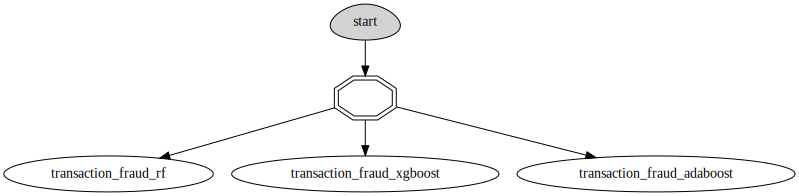

In [ ]:
for model in project.list_models('', tag='latest'):
    name = model.spec.db_key
    serving_fn.add_model(name, class_name="ClassifierModel", model_path=model.uri)

serving_fn.spec.graph.plot()

## Test del Pipeline de Aplicación Localmente

In [ ]:
local_server = serving_fn.to_mock_server()

> 2024-10-08 13:41:43,004 [info] model transaction_fraud_rf was loaded
> 2024-10-08 13:41:43,033 [info] model transaction_fraud_xgboost was loaded
> 2024-10-08 13:41:43,064 [info] model transaction_fraud_adaboost was loaded


Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator AdaBoostClassifier from version 1.5.2 when using version 1.5.0. This might lead to breakin

In [ ]:
sample_id = 'C1000148617'

local_server.test(path='/v2/models/infer',
            body={'inputs': [[sample_id]]})

Input -> [[82.38333699999998, 176.010817, 0.0, 38.79236982490288, 134.16, 417.81, 11.0, 37.982727272727274, 134.16, 1275.0599999999997, 44.0, 28.978636363636358, 90.0, 1.0, 2.0]]
Input -> [[82.38333699999998, 176.010817, 0.0, 38.79236982490288, 134.16, 417.81, 11.0, 37.982727272727274, 134.16, 1275.0599999999997, 44.0, 28.978636363636358, 90.0, 1.0, 2.0]]
Input -> [[82.38333699999998, 176.010817, 0.0, 38.79236982490288, 134.16, 417.81, 11.0, 37.982727272727274, 134.16, 1275.0599999999997, 44.0, 28.978636363636358, 90.0, 1.0, 2.0]]


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names


{'id': 'f7f45c8d7e3a4c6993d6e10cc0f91acd',
 'model_name': 'VotingEnsemble',
 'outputs': [0],
 'model_version': 'v1'}

### Acceso Directo al Vector de Características en Tiempo Real

Si prefieres acceder directamente a las características en tiempo real desde tu aplicación, en lugar de utilizar EnrichmentVotingEnsemble, puedes llamar al método get_online_feature_service() del feature store. Este método se utiliza internamente en la clase de enrutador EnrichmentVotingEnsemble.

In [ ]:
import mlrun.feature_store as fs

In [ ]:
svc = fs.get_feature_vector('short:latest').get_online_feature_service(impute_policy={"*": "$mean"})

sample_fv = svc.get([{'source': sample_id}])
sample_fv

[{'amount_max_2h': 82.38333699999998,
  'amount_max_12h': 134.16,
  'amount_max_24h': 134.16,
  'amount_count_2h': 0.0,
  'amount_count_12h': 11.0,
  'amount_count_24h': 44.0,
  'amount_sum_2h': 176.010817,
  'amount_sum_12h': 417.81,
  'amount_sum_24h': 1275.0599999999997,
  'es_transportation_sum_14d': 90.0,
  'es_health_sum_14d': 1.0,
  'es_otherservices_sum_14d': 2.0,
  'amount_avg_2h': 38.79236982490288,
  'amount_avg_12h': 37.982727272727274,
  'amount_avg_24h': 28.978636363636358}]

## Despliegue de la Función en el Clúster de Kubernetes

Una vez que hayas definido la función, puedes desplegarla en el clúster de Kubernetes. Al hacerlo, obtendrás una función con un disparador HTTP que puede ser llamada desde cualquier ubicación.

In [ ]:
import os

In [ ]:
serving_fn.set_tracking()
project.set_model_monitoring_credentials(None, "v3io", "v3io", "v3io")

serving_fn.deploy()

> 2024-10-08 13:41:43,535 [info] Starting remote function deploy
2024-10-08 13:41:43  (info) Deploying function
2024-10-08 13:41:44  (info) Building
2024-10-08 13:41:44  (info) Staging files and preparing base images
2024-10-08 13:41:44  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2024-10-08 13:41:44  (info) Building processor image
2024-10-08 13:42:49  (info) Build complete
2024-10-08 13:43:13  (info) Function deploy complete
> 2024-10-08 13:43:14,979 [info] Successfully deployed function: {"external_invocation_urls":["fraud-demo-felipe-test-function.default-tenant.app.cust-cs-illl--3-6-0.iguazio-cd2.com/"],"internal_invocation_urls":["nuclio-fraud-demo-felipe-test-function.default-tenant.svc.cluster.local:8080"]}


'http://fraud-demo-felipe-test-function.default-tenant.app.cust-cs-illl--3-6-0.iguazio-cd2.com/'

## Test del server

In [ ]:
sample_id = 'C1000148617'

model_inference_path = '/v2/models/infer'

serving_fn.invoke(path='/v2/models/infer',
                  body={'inputs': [[sample_id]]})

> 2024-10-08 13:43:15,027 [info] Invoking function: {"method":"POST","path":"http://nuclio-fraud-demo-felipe-test-function.default-tenant.svc.cluster.local:8080/v2/models/infer"}


{'id': 'ee5635d0-bb82-4036-a71c-379696d9ed79',
 'model_name': 'VotingEnsemble',
 'outputs': [0],
 'model_version': 'v1'}

### Simulación de una solicitud de usuario

In [ ]:
data = mlrun.get_dataitem(mlrun.get_sample_path("data/fraud-demo-mlrun-fs-docs/data.csv")).as_df()

data = data.sort_values(by='source', axis=0)[:10000]

sample_ids = data['source'].to_list()

In [ ]:
from random import choice, uniform
from time import sleep

In [ ]:
for _ in range(10):
    data_point = choice(sample_ids)
    try:
        resp = serving_fn.invoke(path=model_inference_path, body={'inputs': [[data_point]]})
        print(resp)
        sleep(uniform(0.2, 1.7))
    except OSError:
        pass

> 2024-10-08 13:43:19,205 [info] Invoking function: {"method":"POST","path":"http://nuclio-fraud-demo-felipe-test-function.default-tenant.svc.cluster.local:8080/v2/models/infer"}
{'id': 'efa462b4-36ed-4f63-8d4d-8d6474fff08d', 'model_name': 'VotingEnsemble', 'outputs': [0], 'model_version': 'v1'}
> 2024-10-08 13:43:20,718 [info] Invoking function: {"method":"POST","path":"http://nuclio-fraud-demo-felipe-test-function.default-tenant.svc.cluster.local:8080/v2/models/infer"}
{'id': 'b930f851-fd9a-498a-8b7f-4e84f3bd42ec', 'model_name': 'VotingEnsemble', 'outputs': [0], 'model_version': 'v1'}
> 2024-10-08 13:43:21,987 [info] Invoking function: {"method":"POST","path":"http://nuclio-fraud-demo-felipe-test-function.default-tenant.svc.cluster.local:8080/v2/models/infer"}
{'id': 'c064d2e8-377a-4384-9a47-7c5881f83b0a', 'model_name': 'VotingEnsemble', 'outputs': [0], 'model_version': 'v1'}
> 2024-10-08 13:43:22,928 [info] Invoking function: {"method":"POST","path":"http://nuclio-fraud-demo-felipe-